In [2]:
import sys
sys.path.append("..")
import argparse
import numpy as np
import dgl
from dgl import DGLGraph
import torch
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter
from sklearn.manifold import TSNE
import pickle
import h5py
import random
import glob2
import seaborn as sns
import preprocess
import graph_creator
import train
import models

%load_ext autoreload
%autoreload 2

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
device = train.get_device()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
#path= "../"
# check available files
#!ls ../real_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
X, Y = preprocess.preprocess("F:/class/Fall 22/CAP-6545/CAP_PROJECT - Copy/", "Quake_10x_Spleen")

In [6]:
#data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
#X = np.array(data_mat['X'])
#Y = np.array(data_mat['Y'])
print("Sparsity: ", np.where(X ==0)[0].shape[0]/(X.shape[0]*X.shape[1]))
normalize_weights = "log_per_cell"

n_layers = 1
hidden_dim = 200
hidden = [300]
nb_genes = 3000
activation = F.relu
epochs = 10
batch_size = 128 
pca_size = 50

Sparsity:  0.9433830275221128


In [9]:
# remove less variable genes
genes_idx, cells_idx = preprocess.filter_data(X, highly_genes=nb_genes)
X = X[cells_idx][:, genes_idx]
Y = Y[cells_idx]
n_clusters = len(np.unique(Y))

# create graph
graph = graph_creator.make_graph(
    X,
    Y, # Pass None of Y is not available for validation
    dense_dim=pca_size,
    node_features = "scale_w_PCA",
    normalize_weights=normalize_weights,
)
labels = graph.ndata["label"]
train_ids = np.where(labels != -1)[0]

# create training data loader
sampler = dgl.dataloading.MultiLayerFullNeighborSampler(n_layers)
dataloader = dgl.dataloading.NodeDataLoader(
    graph,
    train_ids,
    sampler,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=1,
)

# create model
model = models.GCNAE(
    in_feats=pca_size,
    n_hidden=hidden_dim,
    n_layers=n_layers,
    activation=activation,
    dropout=0.1,
    hidden=hidden,
).to(device)

optim = torch.optim.Adam(model.parameters(), lr=1e-5)
# train model
results = train.train(model,
                     optim,
                     epochs,
                     dataloader,
                     n_clusters,
                     plot=False,
                     save = True, use_cpu = True,
                     cluster=["KMeans"])

c:\Users\ASUS\anaconda3\lib\site-packages\dgl\heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\ASUS\anaconda3\lib\site-packages\dgl\dataloading\dataloader.py:859: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '
c:\Users\ASUS\anaconda3\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


ARI 0.9125, 0.5412492752075195


In [10]:
results.keys()

dict_keys(['ae_end', 'features', 'y', 'kmeans_ari', 'kmeans_nmi', 'kmeans_sil', 'kmeans_cal', 'kmeans_pred', 'kmeans_time', 'aris_kmeans'])

In [11]:
X_embedded = TSNE(n_components=2).fit_transform(results["features"])

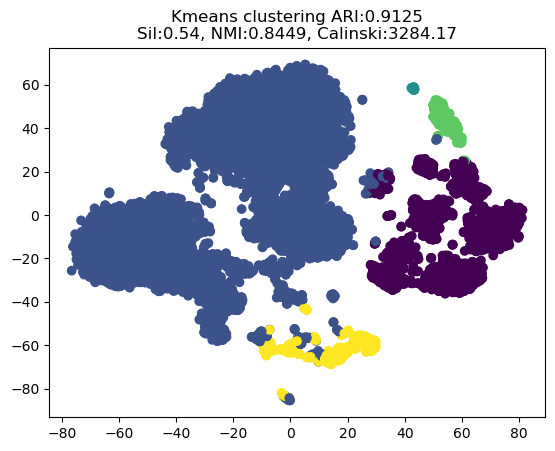

In [12]:
plt.scatter(X_embedded[:,0],X_embedded[:,1], c = results['kmeans_pred'])
plt.title(f"Kmeans clustering ARI:{results['kmeans_ari']}\n"+
          f"Sil:{round(float(results['kmeans_sil']),2)}, NMI:{results['kmeans_nmi']}, "+
          f"Calinski:{round(float(results['kmeans_cal']),2)}"
         );